In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math
import pickle

# from pytorch_metric_learning import losses, miners, distances, reducers, testers
# from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

## Compare between the original VGG and VGG with Exploss on top of last conv

### Viz embedding function and confusion matrix

In [3]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

def visualize_embedding(features, labels, label_dict=None, save_path=None):
    if label_dict is None:
        str_labels = labels
    else:
        str_labels = [label_dict[k] for k in labels]

    tsne_features = TSNE(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], 
                    hue=str_labels, style=str_labels, palette="deep")

    if save_path is not None:
        fig.savefig(save_path)

    return fig, tsne_features


def visualize_cm(cm, save_path=None, str_labels=None):
    
    fig, ax = plt.subplots(figsize=(15,10))
    xticklabels = str_labels if str_labels is not None else 'auto'
    yticklabels = str_labels if str_labels is not None else 'auto'
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

    if save_path is not None:
        fig.savefig(save_path)

    return fig

### Data loader

In [4]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

## Add residual

Hypothesis: the unstable of the the architecture may effect by vastly reconstruct each sample from the attention map without considering the original features. As a result, we add residual connection to observe whether model is more stable or not.

> Result
    Observing the training plot shows that our hypothesis is confirmed. The training plot is more stable. Especially the loss which is less fluctuate than the proposed model without residual connection

In [4]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
    
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
#         mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [5]:
batch_size= 64

# df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')
df = pd.read_csv('../../../data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

# train_set = FERDataset(df_train, train_transforms)
train_set = FERDataset(df_train, test_transforms) # no augmentation!
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

<ipython-input-4-cc86490abb55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]


In [7]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sim_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

## Add residual

Hypothesis: the unstable of the the architecture may effect by vastly reconstruct each sample from the attention map without considering the original features. As a result, we add residual connection to observe whether model is more stable or not.

> Result
    Observing the training plot shows that our hypothesis is confirmed. The training plot is more stable. Especially the loss which is less fluctuate than the proposed model without residual connection

In [6]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
    
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
#         mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [9]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [10]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [11]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_originalimgsize_noaugmentation_model.pt')
model.eval()

sVGG_exp(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [12]:
# register forward hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [13]:
model.features.register_forward_hook(get_activation('before_exploss'))

In [17]:

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_bfeatures = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_bfeatures.append(nn.AdaptiveAvgPool2d(output_size=1)(activation['before_exploss'].cpu()).flatten(1))
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.2122 | Avg. val_acc: 0.9323


In [18]:
exp_bfeatures = torch.cat(exp_bfeatures, axis=0)
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size(), exp_bfeatures.size()

(torch.Size([3589, 512]), torch.Size([3589, 512]))

(<Figure size 1080x720 with 1 Axes>,
 array([[ -6.431156,  31.653248],
        [ 43.350506,  12.443474],
        [-63.840282,   3.763998],
        ...,
        [-42.261913, -35.443317],
        [ 13.436192, -37.380207],
        [-43.544872, -45.773666]], dtype=float32))

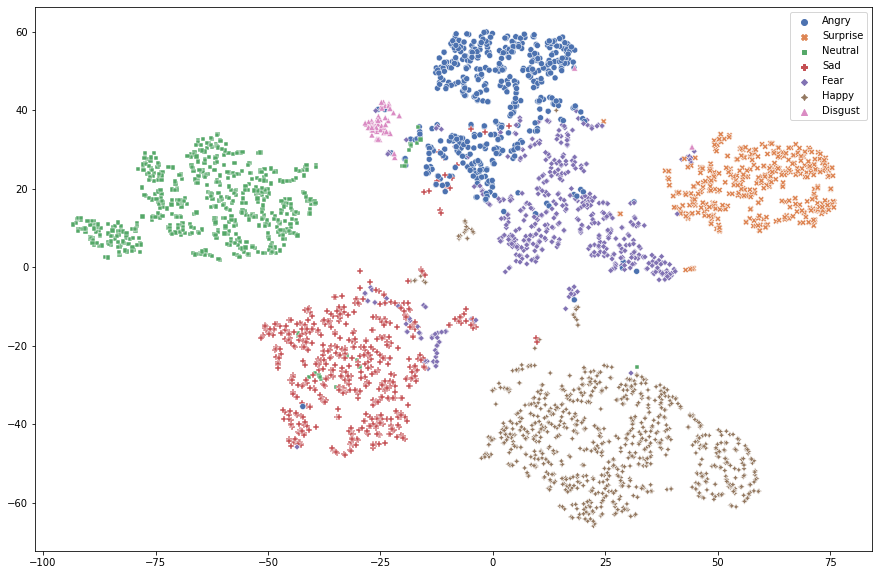

In [19]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)


(<Figure size 1080x720 with 1 Axes>,
 array([[  2.123764 , -18.057209 ],
        [ 54.497585 ,  24.427671 ],
        [ -1.4282775,  -6.064978 ],
        ...,
        [ 16.18849  ,  16.31983  ],
        [ -5.731923 , -34.29098  ],
        [ 37.344643 ,  31.37784  ]], dtype=float32))

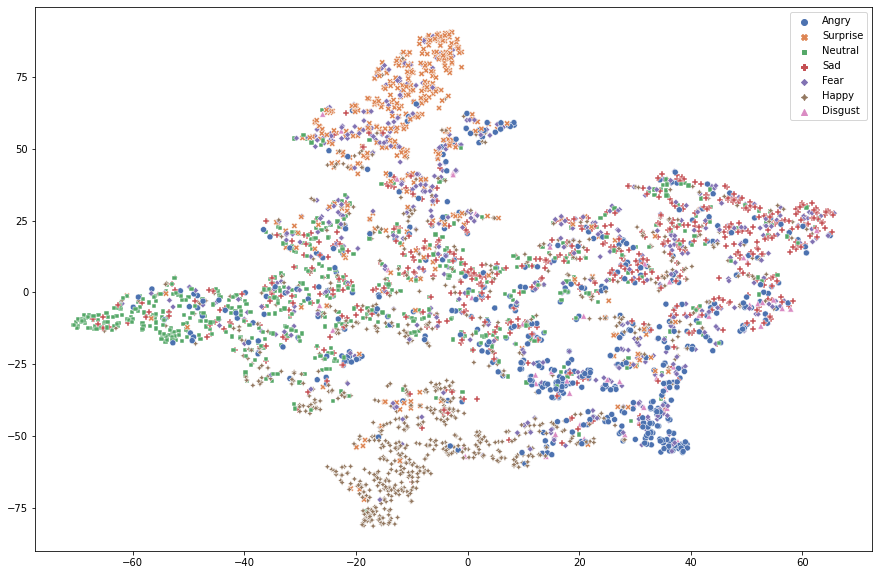

In [20]:
visualize_embedding(exp_bfeatures.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)
